In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import math
import bisect
import statsmodels.api as sm

from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import ttest_1samp
from scipy.stats import kstest
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import pearsonr
from scipy.signal import argrelextrema
from scipy.stats import norm

%matplotlib inline


In [16]:
plt.style.use('seaborn-v0_8-notebook')

# Test stazionarietà

In [2]:
### 1. Check whether the two processes are stationary
### Two common tests are 
### A. Augmented Dickey-Fuller (ADF) Test
### B. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test


### ADF test is conducted with the following assumptions:
### Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
### Alternate Hypothesis(HA): Series is stationary, or series has no unit root.
### If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] > 0.05:
        print("\n*** Time series is not stationary ***\n")
    else:
        print("\n*** Time series is stationary ***\n")

### The KPSS test is conducted with the following assumptions.
### Null Hypothesis (HO): Series is trend stationary or series has no unit root.
### Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.
### Note: The hypothesis is reversed in the KPSS test compared to ADF Test.
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output[1] < 0.05:
        print("\n*** Time series is not stationary ***\n")
    else:
        print("\n*** Time series is stationary ***\n")
        
import warnings
warnings.filterwarnings("ignore")

# Cross correlation analysis

In [70]:
def CrossCorrelationAnalysis(X, Y, maxlag, dt=1):
    """
    Perform the lagged-cross-correlation analysis between two time series X(t) and Y(t).
    X, Y are two 1-d numpy arrays.
    dt is the time step of the time series (default 1 a.u.) - it could be specified w.r.t a given unit
    """
    
    ### Make sure the two time series are stationary
    ### Performing for example the Augmented Dickey-Fuller Test
    from statsmodels.tsa.stattools import adfuller
    result_X, result_Y = adfuller(X), adfuller(Y)
    if (result_X[1] > 0.05 or result_Y[1]>0.05):
        print("Time Series are not stationary")
        return
    else:
        ## we consider X(t+lag), Y(t)
        ## so that for lag<0 X preceeds Y and vice-versa.
        dim = len(X)
        lags = np.arange(-maxlag, maxlag+1, 1)
        lagged_cross_corr = []
        for lag in lags:
            XY = [(X[t+lag], Y[t]) for t in range(dim-np.abs(lag))]
            X_lagged = [el[0] for el in XY]
            Y_lagged = [el[1] for el in XY]
            lagged_cross_corr.append(pearsonr(X_lagged, Y_lagged)[0])
            
        plt.figure(figsize=(6, 3))
        lags_min = [l for l in lags if l<=0]
        lags_maj = [l for l in lags if l>=0]
        lcc_min = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]<=0]
        lcc_maj = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]>=0]
        maximaxi = np.amax(np.abs(lcc_maj))
        idxmf = np.where(lcc_maj == -maximaxi)[0][0]
        zed = lags_maj[idxmf]
        plt.plot(lags_min, lcc_min, lw=0.5, color='b')
        plt.plot(lags_maj, lcc_maj, lw=0.5, color='r')
        plt.vlines(0, -1, 1, lw=0.5, ls='--', color='k')
        plt.xlabel('time lags')
        plt.ylabel('lagged-cross-correlation')
        plt.text(-3*maxlag/2, 0.8, 'Specie precedono Temperature', color='b')
        plt.text(maxlag/2, 0.8, 'Temperature precedono Specie', color='r')
        plt.show()
        print ('con un lag di',  zed , 'abbiamo una cross correlation di ', -maximaxi)

### Gaussiana
Assumo un modello che assume che non ci sia alcuna tendenza o cambiamento significativo nella temperatura media globale nel corso degli anni.

In [5]:
def generate_null_model(mean, variance, num_years):
    """
    Genera una serie di dati simulati basati su una distribuzione gaussiana con media costante e varianza costante
    nel corso del tempo.
    
    Parameters:
        mean (float): la media della distribuzione gaussiana
        variance (float): la varianza della distribuzione gaussiana
        num_years (int): il numero di anni per cui generare i dati
    
    Returns:
        An array of simulated temperature data
    """
    # Generazione dei dati di temperatura simulati
    data = np.random.normal(loc=mean, scale=np.sqrt(variance), size=num_years)
    
    return data

# Robe sul ghiaccio (800k ANNI)

In [8]:
dfv = pd.read_csv('800KyearsData.txt')
# Selezionare due colonne dal DataFrame originale
colonna1 = 2015 - dfv['Age'][12:].round().astype(int)
colonna2 = dfv['Temperature'][12:]

# Creare un nuovo DataFrame con le due colonne selezionate
df800 = pd.DataFrame({'Age': colonna1,'Temperature': colonna2})

df800


,Age,Temperature
12,1977,0.88
13,1968,1.84
14,1960,3.04
15,1951,0.35
16,1942,-0.42
...,...,...
5795,-795393,-8.73
5796,-796428,-8.54
5797,-797486,-8.88
5798,-798574,-8.92


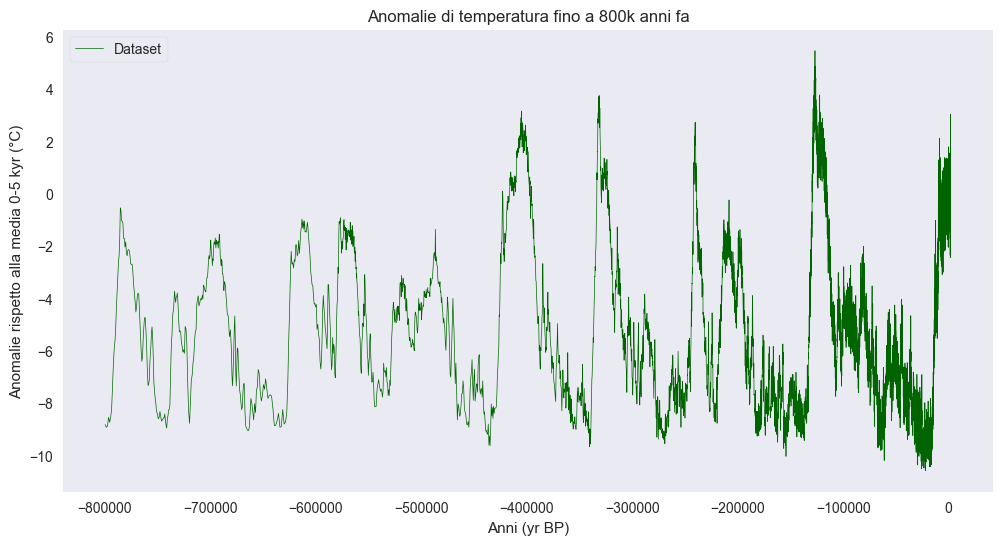

In [17]:
x800=df800['Age']
y800=df800['Temperature']
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x800,y800,'-',color='darkgreen',lw=0.5, label='Dataset')
#ax.scatter(x800,y800,color='darkgreen',s=1)
ax.set_xlabel('Anni (yr BP)')
ax.set_ylabel('Anomalie rispetto alla media 0-5 kyr (°C)')
ax.set_title('Anomalie di temperatura fino a 800k anni fa')
ax.legend(loc='upper left',frameon=True)
ax.plot()
fig.savefig('800kgraph.pdf')

In [39]:
# Definizione del nuovo range di valori per la colonna1
new_colonna1 = np.arange(-799647, 1978, 1)

# Creazione del nuovo dataframe con i valori interpolati
new_df = pd.DataFrame({'Age': new_colonna1})

# Aggiunta della colonna2 con i valori interpolati
interpolated_values = df800.set_index('Age')['Temperature'].\
    reindex(new_colonna1).interpolate(method='linear').values
new_df['Temperature'] = interpolated_values

# Generazione dei numeri casuali e sostituzione dei valori interpolati
random_values = np.random.normal(loc=interpolated_values, scale=0.2) # generazione dei numeri casuali con una deviazione standard di 0.1
new_df.loc[new_df['Temperature'].notnull(), 'Temperature'] = random_values[new_df['Temperature'].notnull()]

# Individuazione dei dati in comune nella prima colonna dei due DataFrame
comuni = pd.merge(df800, new_df, on='Age')

#Sostituzione dei valori originli nel nuovo dataframe
for i in range(len(comuni)):
    # trova l'indice della riga in cui si trova il valore
    indice1 = df800['Age'].eq(comuni['Age'][i]).idxmax()
    a=df800['Temperature'][indice1]
    indice2 = new_df['Age'].eq(comuni['Age'][i]).idxmax()
    new_df.loc[indice2, 'Temperature'] = a

# Stampa del nuovo dataframe
new_df['Temperature'] = new_df['Temperature'].round(2)
jc = new_df[::50]
jc

,Age,Temperature
0,-799647,-8.82
50,-799597,-8.99
100,-799547,-8.74
150,-799497,-9.17
200,-799447,-8.76
...,...,...
801400,1753,-0.18
801450,1803,-2.44
801500,1853,0.98
801550,1903,0.80


In [40]:
# Esegui il test di Kolmogorov-Smirnov
statistica_test, p_value = stats.ks_2samp(jc['Temperature'], y800)

# Stampa i risultati del test
print("Statistica del test di Kolmogorov-Smirnov: ", statistica_test)
print("Valore p del test di Kolmogorov-Smirnov: ", p_value)

# Confronta il valore p con un livello di significatività (ad esempio 0.05) per trarre una conclusione
ls = 0.05
if p_value < ls:
    print("I campioni NON seguono la stessa distribuzione")
else:
    print("I campioni seguono la stessa distribuzione")


Statistica del test di Kolmogorov-Smirnov:  0.00690536601488817
Valore p del test di Kolmogorov-Smirnov:  0.9592191109141328
I campioni seguono la stessa distribuzione


In [41]:
diff2=[]
y800 = jc['Temperature'].values
x800 = jc['Age'].values
for i in range(len(jc['Temperature'])-1):
    a = y800[i+1]-y800[i]
    diff2.append(a)
numeri_arrotondati2 = [round(num, 2) for num in diff2]
print('la media di variazioni di temperatura rispetto a 50 anni prima è: ',np.mean(numeri_arrotondati2))
print('la massima variazione di temperatura rispetto a 50 anni prima è: ', np.amax(numeri_arrotondati2))
print('la deviazione standard del campione è: ', np.std(numeri_arrotondati2))

la media di variazioni di temperatura rispetto a 50 anni prima è:  0.0006000499001996009
la massima variazione di temperatura rispetto a 50 anni prima è:  3.42
la deviazione standard del campione è:  0.39381872776611176


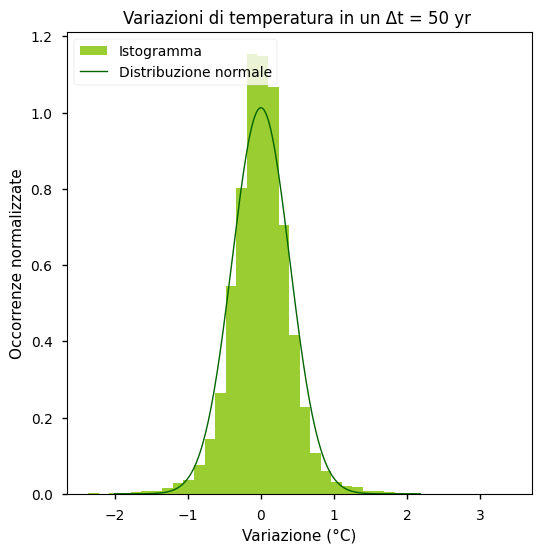

In [46]:

deviazione_standard2 = np.std(numeri_arrotondati2)
gaussx2 = np.arange(-2,2.2, 0.02)
media2 = np.mean(numeri_arrotondati2)
gaussy2 = (1 / (deviazione_standard2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((gaussx2 - media2) / deviazione_standard2) ** 2)
fig, ax1 = plt.subplots(figsize=(6,6))
ax1.hist(diff2, bins=40, color='yellowgreen',density=True, label='Istogramma')
ax1.plot(gaussx2,gaussy2, lw=1, color='darkgreen', label='Distribuzione normale')
ax1.set_xlabel('Variazione (°C)')
ax1.set_ylabel('Occorrenze normalizzate')
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True)
ax1.set_title('Variazioni di temperatura in un \u0394t = 50 yr ')
fig.savefig('800kanalysis.pdf')

## Z test

In [43]:
# Media e deviazione standard del campione
media_campione = media2
deviazione_standard_campione = deviazione_standard2

# Valore di riferimento (ipotetica media di riferimento)
media_riferimento = 0.89

# Calcola il valore di Z
z_valore = np.abs(media_campione - media_riferimento) / (deviazione_standard_campione)

# Calcola la p-value
p_value = 1 - norm.cdf(z_valore)

# Stampa il risultato
print("Valore di Z:", z_valore)
print("P-value:", p_value)

# Verifica se il risultato è statisticamente significativo (ad esempio, se la p-value è inferiore a una soglia di significatività predefinita)
soglia_significativita = 0.05
if p_value > soglia_significativita:
    print("Il risultato è statisticamente significativo.")
else:
    print("Il risultato non è statisticamente significativo.")


Valore di Z: 2.258399327895888
P-value: 0.011960387298554864
Il risultato non è statisticamente significativo.


[]

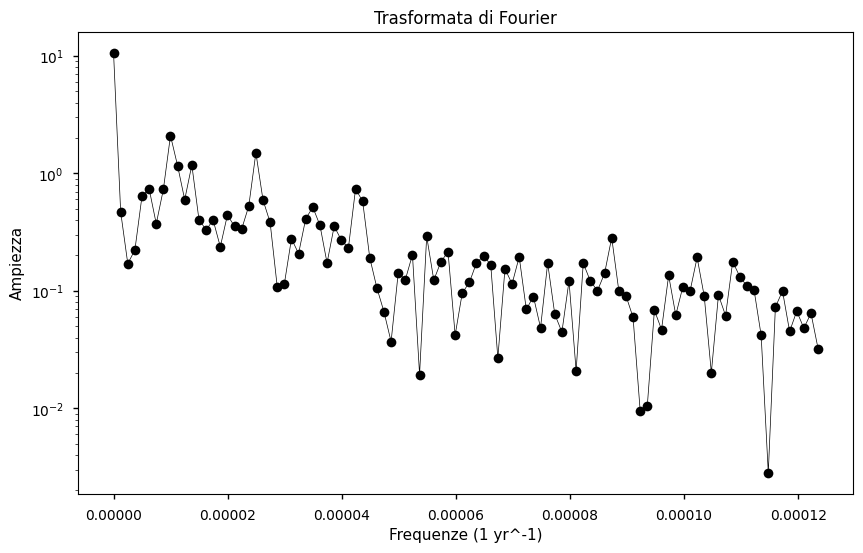

In [13]:
yf800 = new_df['Temperature'].values
xf800 = new_df['Age'].values
sep=abs(xf800[1]-xf800[0])
N = len(yf800)
yt = np.fft.fft(yf800)
# Calcolare le frequenze associate alla DFT
xf = np.linspace(0.0, 1.0/(2.0*sep), N//2)
yf = 2.0/N * np.abs(yt[:N//2])
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(xf[0:100],yf[0:100],'o-',color='k', lw=0.5)
ax.set_xlabel('Frequenze (1 yr^-1)')
ax.set_ylabel('Ampiezza')
ax.set_title('Trasformata di Fourier')
ax.set_yscale('log')
ax.plot()

# 2000 anni 

In [14]:
df2=pd.read_csv('2kyearsData.csv')
df2


,Year,Surface temperature anomaly,3.5 percentiles,4.95 percentiles,Unnamed: 4
0,1995,0.65,0.46,0.79,NaN
1,1994,0.64,0.46,0.77,NaN
2,1993,0.62,0.45,0.76,NaN
3,1992,0.61,0.45,0.74,NaN
4,1991,0.59,0.44,0.71,NaN
...,...,...,...,...,...
1986,9,0.10,-0.11,0.38,NaN
1987,8,0.10,-0.11,0.38,NaN
1988,7,0.09,-0.11,0.38,NaN
1989,6,0.09,-0.12,0.37,NaN


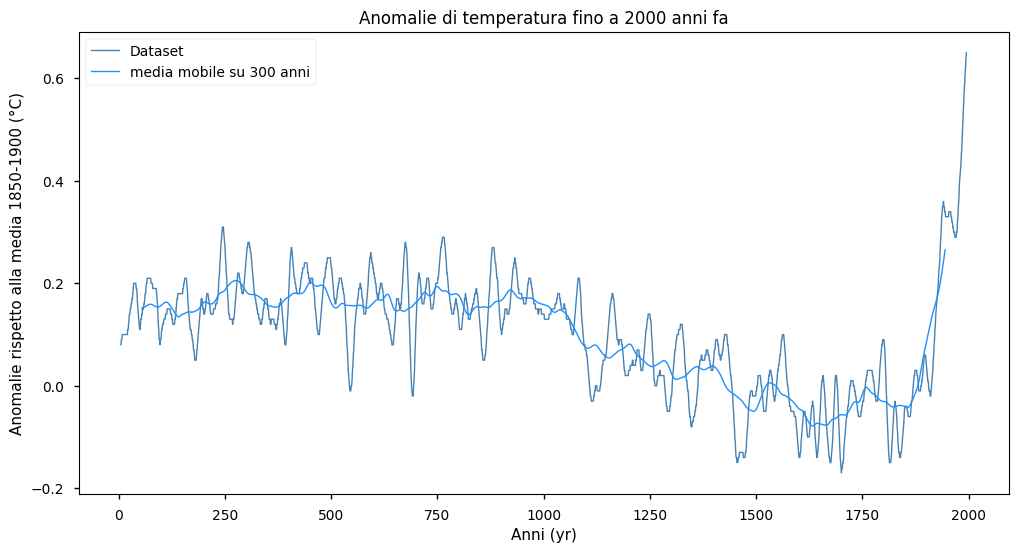

In [76]:

x = df2.iloc[:, 0]
y = df2.iloc[:, 1]

df4 = y.rolling(100,center=True).mean()
std = np.var(y-df4)
z = generate_null_model(0, std, 1991)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x, y,lw=1,label='Dataset',color='steelblue')
ax.plot(x,df4,lw=1,label='media mobile su 300 anni', color='dodgerblue')
# aggiungi un titolo al grafico
ax.set_title('Anomalie di temperatura fino a 2000 anni fa')

# aggiungi una label all'asse x
ax.set_xlabel('Anni (yr)')

# aggiungi una label all'asse y
ax.set_ylabel('Anomalie rispetto alla media 1850-1900 (°C)')

# mostra il grafico
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True)
plt.show()
fig.savefig('2kgraph.pdf')

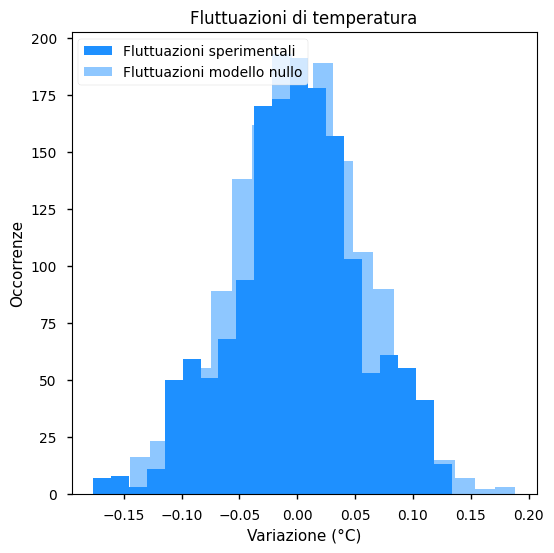

In [16]:
idx8 = x.index[x == 1850].tolist()[0]

fig, ax1 = plt.subplots(figsize=(6,6))
ax1.hist(y[idx8:len(y)-300]-df4[idx8:len(y)-300], color='dodgerblue', label='Fluttuazioni sperimentali', bins = 20)
ax1.hist(z[idx8:len(y)-300], color='dodgerblue',alpha=0.5,label='Fluttuazioni modello nullo', bins = 20)
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True)
ax1.set_xlabel('Variazione (°C)')
ax1.set_ylabel('Occorrenze')
ax1.set_title('Fluttuazioni di temperatura')
fig.savefig('2kanalysis.pdf')

In [17]:

# Due campioni di dati di esempio
campione1 = y[idx8:len(y)-300]-df4[idx8:len(y)-300]
campione2 = z[idx8:len(y)-300]

# Esegui il test di Kolmogorov-Smirnov
statistica_test, p_value = stats.ks_2samp(campione1, campione2)

# Stampa i risultati del test
print("Statistica del test di Kolmogorov-Smirnov: ", statistica_test)
print("Valore p del test di Kolmogorov-Smirnov: ", p_value)

# Confronta il valore p con un livello di significatività (ad esempio 0.05) per trarre una conclusione
ls = 0.05
if p_value < ls:
    print("I campioni NON seguono la stessa distribuzione")
else:
    print("I campioni seguono la stessa distribuzione")


Statistica del test di Kolmogorov-Smirnov:  0.028460543337645538
Valore p del test di Kolmogorov-Smirnov:  0.5585340572317458
I campioni seguono la stessa distribuzione


In [18]:
md = np.mean(y[0:idx8])
vr46 = np.var(y[0:idx8])
cmp2 = generate_null_model(md, vr46, idx8)
cmp1 = y[0:idx8]
# Esegui il test di Kolmogorov-Smirnov
statistica_test1, p_value1 = stats.ks_2samp(cmp1, cmp2)

# Stampa i risultati del test
print("Statistica del test di Kolmogorov-Smirnov: ", statistica_test1)
print("Valore p del test di Kolmogorov-Smirnov: ", p_value1)

# Confronta il valore p con un livello di significatività (ad esempio 0.05) per trarre una conclusione
if p_value1 < ls:
    print("I campioni NON seguono la stessa distribuzione")
else:
    print("I campioni seguono la stessa distribuzione")


Statistica del test di Kolmogorov-Smirnov:  0.22758620689655173
Valore p del test di Kolmogorov-Smirnov:  0.0010521881725381304
I campioni NON seguono la stessa distribuzione


# 150 anni ammò

In [3]:
ccq = pd.read_excel('dati buoni.xlsx')
mmob = ccq['HadCRUT'].rolling(10,center=True).mean()
ccq
idxmg = ccq.index[ccq['Year'] == 2022].tolist()[0]
diffe = np.abs(ccq['HadCRUT'][idxmg]-ccq['HadCRUT'][idxmg-52])
print(diffe)

0.89


I parametri del fit sono:
a = 0.01940170939956165
b = -38.28694404135084


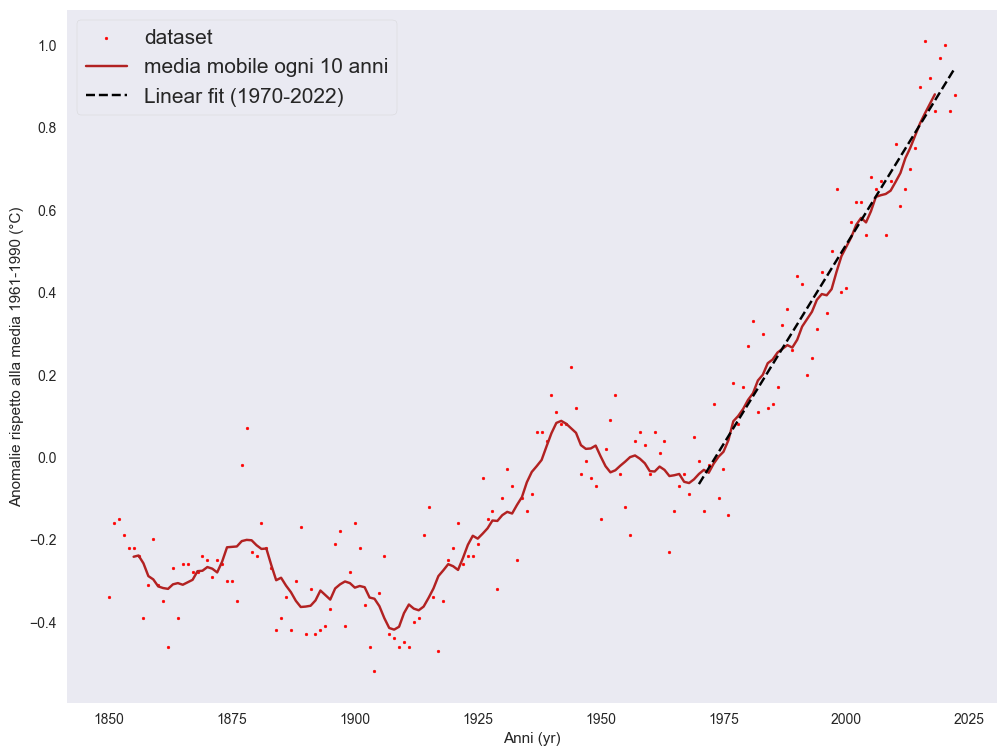

In [15]:
# definisci una funzione lineare
def linear_func(x, a, b):
    return a*x+b
# seleziona i dati 
xdat = ccq['Year'][120:]
ydat = ccq['HadCRUT'][120:]
# esegui il fit
popt, pcov = curve_fit(linear_func, xdat, ydat)
a = popt[0]
b = popt[1]
# stampa i parametri del fit
print('I parametri del fit sono:')
print('a =',a)
print('b =', b)
# crea un grafico dei dati e della curva di fit

fig, ax = plt.subplots(figsize=(12,9))
ax.scatter(ccq.get('Year'),ccq.get('HadCRUT'),s=4,label='dataset', color='red')
ax.plot(ccq.get('Year'), mmob, label='media mobile ogni 10 anni', color='firebrick')
ax.plot(xdat,linear_func(xdat, *popt), label='Linear fit (1970-2022)',linestyle = '--', color='k')
ax.legend(loc='upper left', bbox_to_anchor=(0, 1),frameon=True,fontsize=15)
ax.set_xlabel('Anni (yr)')
ax.set_ylabel('Anomalie rispetto alla media 1961-1990 (°C)')
fig.savefig('150data.pdf')

In [21]:
y_nm = a*xdat+b


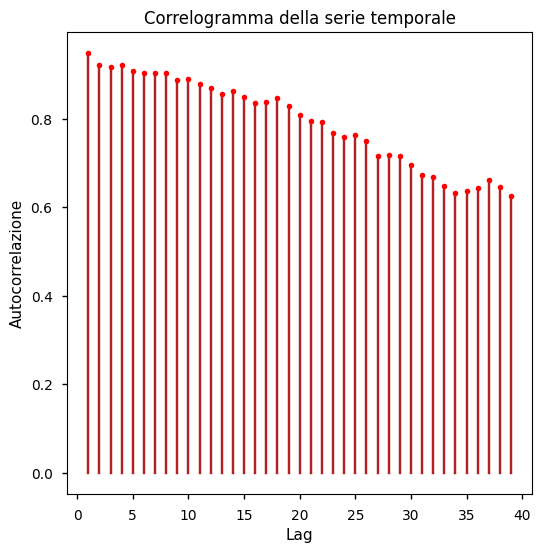

In [22]:
# Calcolare l'autocorrelazione
lags = range(1, 40)
autocorr = [ccq['HadCRUT'].autocorr(lag) for lag in lags]
fig, ax = plt.subplots(figsize=(6,6))
# Creare il plot dell'autocorrelazione
for lag, autocorr in zip(lags, autocorr):
    ax.plot([lag, lag], [0, autocorr], '-',color='firebrick')  # Linee tratteggiate blu
    ax.plot(lag, autocorr, 'ro', markersize=4)  # Punti blu

# Aggiunta di titolo e label all'asse x
ax.set_title('Correlogramma della serie temporale')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelazione')

# Mostra il plot
plt.show()
fig.savefig('150analiysis.pdf')

# Estinzioni

In [23]:
dc=pd.read_csv('500Mdata.txt', sep='\t')
dl=pd.read_csv('Species_new.txt',sep='\t')
dl

,Age (Ma),All Genera,Well-Resolved,Cubic Fit,From Cubic
0,0,5283,4166,3976,190
1,1,5283,4166,3939,227
2,2,5274,4063,3901,161
3,3,5274,4063,3864,198
4,4,5180,3942,3828,114
...,...,...,...,...,...
537,537,63,47,-126,173
538,538,27,16,-145,161
539,539,27,16,-165,181
540,540,27,16,-184,200


Interpolo i valori mancanti:

In [24]:
# Definizione del nuovo range di valori per la colonna1
new_colonna1 = np.arange(0, 499, 1)

# Creazione del nuovo dataframe con i valori interpolati
new_df = pd.DataFrame({'Age (Ma)': new_colonna1})

# Aggiunta della colonna2 con i valori interpolati
interpolated_values = dc.set_index('Age (Ma)')['Mean temperature (°C)'].\
    reindex(new_colonna1).interpolate(method='linear').values
new_df['Mean temperature (°C)'] = interpolated_values

# Generazione dei numeri casuali e sostituzione dei valori interpolati
random_values = np.random.normal(loc=interpolated_values, scale=0.2) # generazione dei numeri casuali con una deviazione standard di 0.1
new_df.loc[new_df['Mean temperature (°C)'].notnull(), 'Mean temperature (°C)'] = random_values[new_df['Mean temperature (°C)'].notnull()]

# Individuazione dei dati in comune nella prima colonna dei due DataFrame
comuni = pd.merge(dc, new_df, on='Age (Ma)')

#Sostituzione dei valori originli nel nuovo dataframe
for i in range(len(comuni)):
    # trova l'indice della riga in cui si trova il valore
    indice1 = dc['Age (Ma)'].eq(comuni['Age (Ma)'][i]).idxmax()
    a=dc['Mean temperature (°C)'][indice1]
    indice2 = new_df['Age (Ma)'].eq(comuni['Age (Ma)'][i]).idxmax()
    new_df.loc[indice2, 'Mean temperature (°C)'] = a



# Stampa del nuovo dataframe
new_df['Mean temperature (°C)'] = new_df['Mean temperature (°C)'].round(2)
new_df

,Age (Ma),Mean temperature (°C)
0,0,18.22
1,1,15.38
2,2,16.19
3,3,17.16
4,4,17.47
...,...,...
494,494,48.88
495,495,50.19
496,496,47.37
497,497,42.97


In [25]:
x1=new_df['Age (Ma)'][0:]
y1=new_df['Mean temperature (°C)'][0:]
x2=dl['Age (Ma)'][0:]
y2=dl['Well-Resolved'][0:]
# Definisci la finestra di smoothing
span = 0.1

# Esegui la regressione lineare pesata localmente
lowess = sm.nonparametric.lowess(y1, x1, frac=span)
lowess2 = sm.nonparametric.lowess(y2, x2, frac=span)

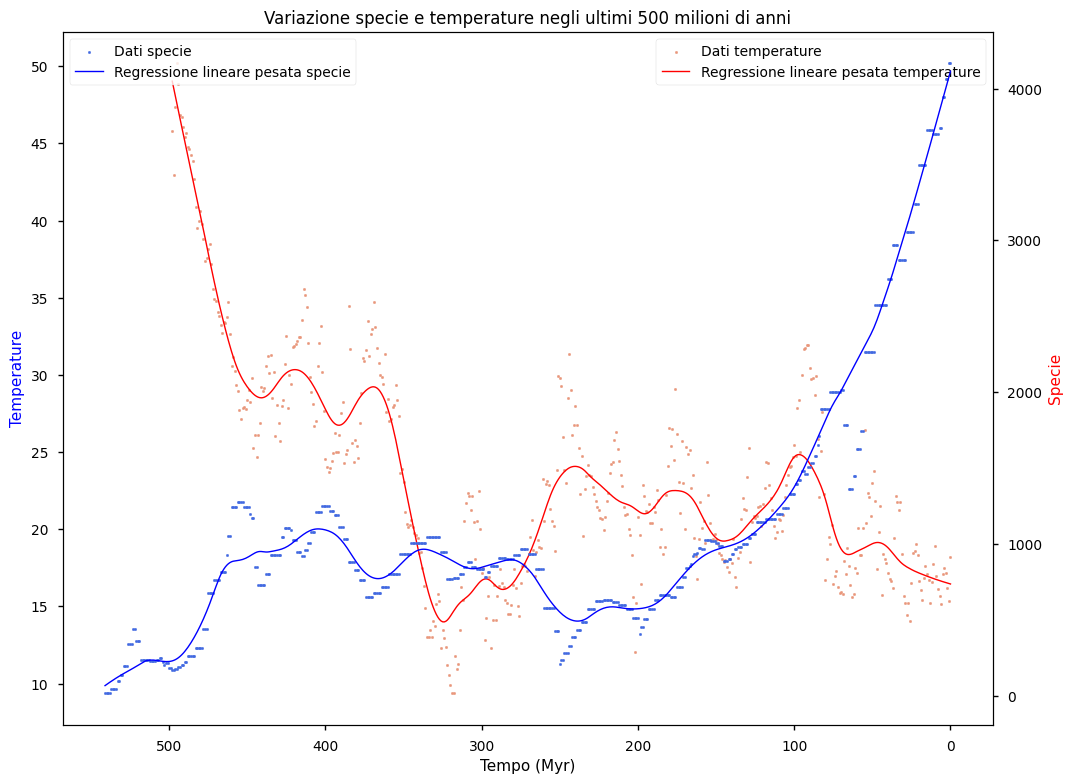

In [26]:
# crea il grafico
fig, ax1 = plt.subplots(figsize=(12,9))
# plotta y1 sul primo asse y
ax1.scatter(x1, y1, color='darksalmon',s=3, label='Dati temperature')
ax1.plot(lowess[:, 0], lowess[:, 1], color='red',lw=1, label='Regressione lineare pesata temperature')
ax1.set_ylabel('Temperature', color='blue')
ax1.set_xlabel('Tempo (Myr)')
ax1.invert_xaxis()
# crea un secondo asse y che condivide l'asse x con il primo
ax2 = ax1.twinx()
# plotta y2 sul secondo asse y
ax2.scatter(x2, y2, color='royalblue',s=3, label='Dati specie')
ax2.plot(lowess2[:, 0], lowess2[:, 1], color='blue',lw=1, label='Regressione lineare pesata specie')
ax2.set_ylabel('Specie', color='red')
# mostra il grafico
ax1.legend(loc='best',frameon=True)
ax2.legend(loc='best',frameon=True)
ax1.set_title('Variazione specie e temperature negli ultimi 500 milioni di anni')
plt.show()
fig.savefig('SpecieTempdata.pdf')

In [27]:
# Eseguo un fit cubico ai dati della temperatura
coefficients = np.polyfit(x1, y1, 3)
a=coefficients[0]
b=coefficients[1]
c=coefficients[2]
d=coefficients[3]
yc=a*x1**3+b*x1**2+c*x1+d
y3=y1-yc

In [28]:
X_t = dl['From Cubic'][0:499]
Y_t = y3[0:499]
adf_test(X_t)
kpss_test(X_t)
adf_test(Y_t)
kpss_test(Y_t)

Results of Dickey-Fuller Test:
Test Statistic                  -4.432146
p-value                          0.000260
#Lags Used                      10.000000
Number of Observations Used    488.000000
Critical Value (1%)             -3.443821
Critical Value (5%)             -2.867481
Critical Value (10%)            -2.569934
dtype: float64

*** Time series is stationary ***

Results of KPSS Test:
Test Statistic            0.056989
p-value                   0.100000
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

*** Time series is stationary ***

Results of Dickey-Fuller Test:
Test Statistic                  -3.567577
p-value                          0.006412
#Lags Used                       8.000000
Number of Observations Used    490.000000
Critical Value (1%)             -3.443766
Critical Value (5%)             -2.867457
Critical Value (10%)   

In [29]:
#trovo il massimo della serie delle specie
max_sp = np.amax(np.abs(X_t))
#definisco il coeficiente di normalizzazione
a1 = 1/max_sp
#rifaccio per le temperature
max_tmp = np.amax(np.abs(Y_t))
a2 = 1/max_tmp
#normalizzo le serie
X_t = a1 * X_t
Y_t = a2 * Y_t

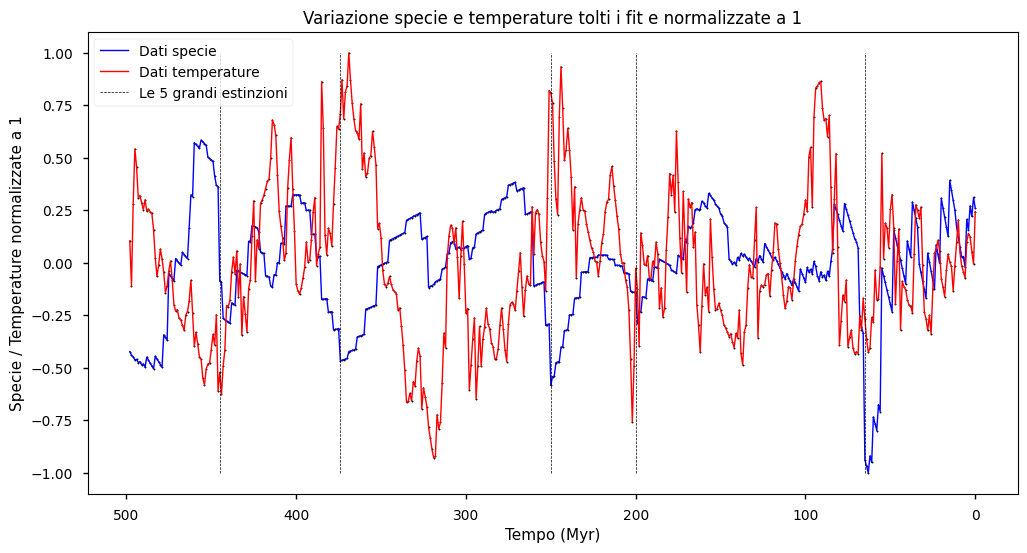

In [30]:
# crea il grafico
fig, ax1 = plt.subplots(figsize=(12,6))
# plotta y1 sul primo asse y
ax1.plot(x2[0:499], X_t, color='blue',lw=1, label='Dati specie')
ax1.plot(x1, Y_t, color='red',lw=1, label='Dati temperature')
ax1.scatter(x2[0:499], X_t, color='k',s=1)
ax1.scatter(x1, Y_t, color='k',s=1)
ax1.plot([65,65], [-1, 1], color='black', linestyle='--',lw=0.5,label='Le 5 grandi estinzioni') 
ax1.plot([200,200], [-1, 1], color='black', linestyle='--',lw=0.5)
ax1.plot([250,250], [-1, 1], color='black', linestyle='--',lw=0.5)
ax1.plot([374,374], [-1, 1], color='black', linestyle='--',lw=0.5)
ax1.plot([445,445], [-1, 1], color='black', linestyle='--',lw=0.5)
ax1.invert_xaxis()
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True)
ax1.set_xlabel('Tempo (Myr)')
ax1.set_ylabel('Specie / Temperature normalizzate a 1')
ax1.set_title('Variazione specie e temperature tolti i fit e normalizzate a 1')
plt.show()
fig.savefig('SpeTempNorm.pdf')


In [58]:
X_t1=X_t.values
Y_t1=Y_t.values
al = X_t.corr(Y_t)
ali = X_t[64:len(X_t1)].corr(Y_t[64:len(X_t1)])
al1 = X_t[199:len(X_t1)].corr(Y_t[199:len(X_t1)])
al2 = X_t[249:len(X_t1)].corr(Y_t[249:len(X_t1)])
al3 = X_t[374:len(X_t1)].corr(Y_t[374:len(X_t1)])
al4 = X_t[449:len(X_t1)].corr(Y_t[449:len(X_t1)])
print(al,ali, al1, al2,al3,al4)

-0.3619719299552883 -0.4548520113887503 -0.5474985911445117 -0.5423452966253036 -0.4483230774675392 -0.8748150162315877


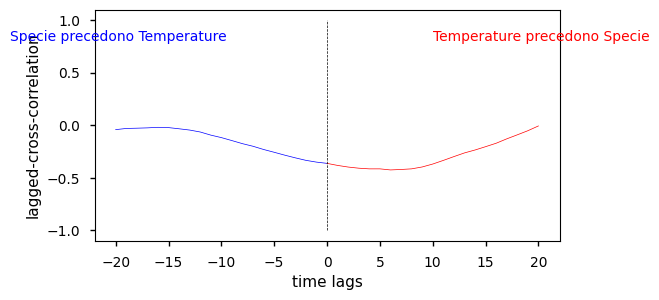

con un lag di 6 abbiamo una cross correlation di  -0.4245010938786729


In [71]:
CrossCorrelationAnalysis(X_t1, Y_t1, maxlag=(20), dt=1)
#y è temperature
#x è specie

In [34]:
# Calcola la trasformata di Fourier dei dati di speicie
fft = np.fft.fft(X_t)
# Calcolare le frequenze associate alla DFT
N = len(X_t)
xf1 = np.linspace(0.0, 0.5, N//2)
yf1 = 2.0/N * np.abs(fft[:N//2])/10



In [35]:
tffos=pd.read_csv('TFFOS.txt',sep='\t')
xf3=tffos['Cycles (Myr)'][0:500]
yf3=tffos['Spectral Power'][0:500]
xfs=xf3[::20]
yfs=yf3[::20]

In [36]:
# Calcola la trasformata di Fourier dei dati
fft_data = np.fft.fft(y3)
# Calcolare le frequenze associate alla DFT
N = len(y3)
xf2 = np.linspace(0.0, 0.5, N//2)
yf2 = 2.0/N * np.abs(fft_data[:N//2])

# Crea una funzione interpolante
f = interp1d(xf2[0:50], yf2[0:50], kind='cubic')

# Crea un nuovo insieme di dati più "fitti"
x_new = np.linspace(xf2[0], xf2[49], num=10000, endpoint=True)
y_new = f(x_new)

indici_massimi = np.argsort(yf2)[::-1][:3]
# Prendi le x corrispondenti agli indici massimi
x_massimi = xf2[indici_massimi]
print("Le tre frequenze corrispondenti alle tre y massime sono:", x_massimi)
print("Che corrispondono a dei periodi:")
for i in range(3):
    print(i+1, 1/x_massimi[i])

Le tre frequenze corrispondenti alle tre y massime sono: [0.00604839 0.00806452 0.01612903]
Che corrispondono a dei periodi:
1 165.33333333333334
2 124.0
3 62.0


In [72]:
# Media e deviazione standard del campione
media1 = 140
std1 = 15

# Valore di riferimento (ipotetica media di riferimento)
mdr = 124

# Calcola il valore di Z
z_valore = np.abs(media1 - mdr) / (std1)

# Calcola la p-value
p_value = 1 - norm.cdf(z_valore)

# Stampa il risultato
print("Valore di Z:", z_valore)
print("P-value:", p_value)

# Verifica se il risultato è statisticamente significativo (ad esempio, se la p-value è inferiore a una soglia di significatività predefinita)
soglia_significativita = 0.05
if p_value > soglia_significativita:
    print("Il risultato è statisticamente significativo.")
else:
    print("Il risultato non è statisticamente significativo.")

Valore di Z: 1.0666666666666667
P-value: 0.14306119219550917
Il risultato è statisticamente significativo.


In [73]:
# Media e deviazione standard del campione
media1 = 140
std1 = 15

# Valore di riferimento (ipotetica media di riferimento)
mdr = 165

# Calcola il valore di Z
z_valore = np.abs(media1 - mdr) / (std1)

# Calcola la p-value
p_value = 1 - norm.cdf(z_valore)

# Stampa il risultato
print("Valore di Z:", z_valore)
print("P-value:", p_value)

# Verifica se il risultato è statisticamente significativo (ad esempio, se la p-value è inferiore a una soglia di significatività predefinita)
soglia_significativita = 0.05
if p_value > soglia_significativita:
    print("Il risultato è statisticamente significativo.")
else:
    print("Il risultato non è statisticamente significativo.")

Valore di Z: 1.6666666666666667
P-value: 0.047790352272814696
Il risultato non è statisticamente significativo.


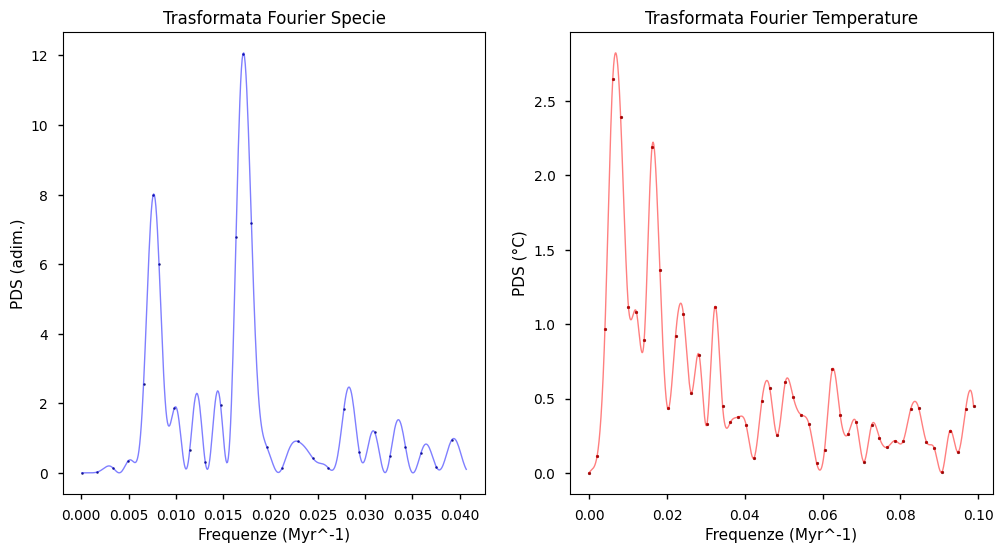

In [37]:
xmaxi = [(1/135)+0.0002,(1/59)+0.00017]
ymaxi = [8,12.045]
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax2.plot(x_new, y_new, '-', linewidth=1.0, color='red',alpha=0.5)
ax2.scatter(xf2[0:50], yf2[0:50], s=4, color='darkred')
ax2.set_title('Trasformata Fourier Temperature')
ax2.set_xlabel('Frequenze (Myr^-1)')
ax2.set_ylabel('PDS (°C)')
ax1.plot(xf3,yf3,lw=1,color='blue',alpha=0.5)
ax1.scatter(xfs,yfs,s=2,color='midnightblue')
ax1.scatter(xmaxi,ymaxi,s=2,color='midnightblue')
ax1.set_title('Trasformata Fourier Specie')
ax1.set_xlabel('Frequenze (Myr^-1)')
ax1.set_ylabel('PDS (adim.)')
plt.show()
fig.savefig('FourierSpeTemp.pdf')